# K-Means Clustering

# Data Crawling

```python
import scrapy


class BlogSpider(scrapy.Spider):
    name = 'blog'
    allowed_domains = ['pta.trunojoyo.ac.id']
    start_urls = ['https://pta.trunojoyo.ac.id/c_search/byprod/7']

    def __init__(self, name=None, **kwargs):
        kwargs['include_headers_line'] = False
        self.count = 0
        super().__init__(name, **kwargs)

    def parse(self, response):
        for url in response.css('a.gray.button'):
            yield response.follow(url.attrib['href'], self.parse_item)
        if self.count < 12:
            self.count += 1
            yield response.follow(response.xpath("//*[@class='pag_button' and contains(text(), '>')]").attrib['href'], self.parse)

    def parse_item(self, response):
        yield {
            "judul": response.css('a.title::text').get(),
            "penulis": response.xpath('//*[@id="content_journal"]/ul/li/div[2]/div[1]/span/text()').get()[10:],
            "dospem1": response.xpath('//*[@id="content_journal"]/ul/li/div[2]/div[2]/span/text()').get()[21:],
            "dospem2": response.xpath('//*[@id="content_journal"]/ul/li/div[2]/div[3]/span/text()').get()[21:],
            "abstrak": response.xpath('//*[@id="content_journal"]/ul/li/div[4]/div[2]/p/text()').get(),
        }

```

# Imports
Pertama-tama kita membutuhkan library yang akan dipakai untuk pemrosesan ini, diantaranya adalah:

- [x] numpy
- [x] regex
- [x] pandas
- [x] nltk
- [x] sklearn
- [x] sastrawi

In [1]:
import regex as re
import pandas as pd
import nltk
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import randomized_svd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /home/zaka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/zaka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Global Vars

| Variable   | Reference       | Library  |
| ---------- | --------------- | -------- |
| factory    | StemmerFactory  | Sastrawi |
| vectorizer | CountVectorizer | sklearn  |factory_dictionary
| tfidf      | TfidfVectorizer | sklearn  |
| idf        | TfidfVectorizer | sklearn  |

In [2]:
factory = StemmerFactory()
vectorizer = CountVectorizer()
tfidf = TfidfVectorizer()
idf = TfidfVectorizer(use_idf=True)
factory_dictionary = factory.get_words()
stemmer = factory.create_stemmer()
docs = pd.read_csv('data_kmeans.csv', usecols=['abstrak'])
docs = docs.rename(columns={'abstrak': 'raw'})
indo_stopwords = stopwords.words('indonesian')
indo_stopwords.extend(stopwords.words('english'))

# Cleaning & Tokenizing
Data yang sudah dicrawling akan dibersihkan dan akan di _tokenisasi_. data dibersihkan dengan membuang _punctuation_. kemudian _punctuation_ tersebut akan diganti dengan spasi

##### Punctuation Table
| Name             | Character | Example |
| ---------------- | --------- | ------- |
| Full Stop        | .         | .       |
| Comma            | ,         | ,       |
| Question Mark    | ?         | ?       |
| Exclamation Mark | !         | !       |
| Quotation Marks  | " "       | "word"  |
| Apestrophe       | `         | `       |
| Hypen            | -         | -       |
| Dash             | -         | -or--   |
| Colon            | :         | :       |
| Semicolon        | ;         | ;       |
| Parantheses      | ()        | ()      |
| Brackets         | []        | []      |
| Ellipsis         | ...       | ...     |
| Slash            | /         | /       |

In [3]:
docs['text'] = docs['raw'].apply(
    lambda x: word_tokenize(re.sub('[^a-zA-Z]', ' ', str(x).lower())))
docs.head()

,raw,text
0,Sistem informasi akademik (SIAKAD) merupaka...,"[sistem, informasi, akademik, siakad, merupaka..."
1,Web server adalah sebuah perangkat lunak serve...,"[web, server, adalah, sebuah, perangkat, lunak..."
2,"Perkembangan game yang semakin pesat, memberik...","[perkembangan, game, yang, semakin, pesat, mem..."
3,Sistem pengenalan wajah adalah suatu sistem un...,"[sistem, pengenalan, wajah, adalah, suatu, sis..."
4,Berjalannya koneksi jaringan komputer dengan l...,"[berjalannya, koneksi, jaringan, komputer, den..."


# Stopwords
Didalam _text mining_ terdapat _stopwords_, dimana itu adalah kumpulan kosa kata yang tidak mengandung arti sehingga tidak diperlukan untuk proses _mining_ nanti. Jika kata terdeteksi sebagai _stopwords_ maka kata tersebut akan dihapus dari sebuah dokumen

#### Stopwords Dictionary
<a href="https://gist.github.com/sebleier/554280" title="NLTK's list of english stopwords">English Stopwords Dictionary</a>

<a href="https://github.com/stopwords-iso/stopwords-id/blob/master/raw/indonesian-stopwords-complete.txt" title="indonesian-stopwords-complete.txt">Indonesian Stopwords Dictionary</a>

> Kedua _stopwords_ tadi digabung menjadi satu

In [4]:
docs['text'] = docs['text'].apply(
    lambda doc: [d for d in doc if d not in indo_stopwords])
    # lambda doc: [d for d in doc if d not in indo_stopwords and d in factory_dictionary])
docs.head()

,raw,text
0,Sistem informasi akademik (SIAKAD) merupaka...,"[sistem, informasi, akademik, siakad, sistem, ..."
1,Web server adalah sebuah perangkat lunak serve...,"[web, server, perangkat, lunak, server, berfun..."
2,"Perkembangan game yang semakin pesat, memberik...","[perkembangan, game, pesat, alternative, pemin..."
3,Sistem pengenalan wajah adalah suatu sistem un...,"[sistem, pengenalan, wajah, sistem, mengenali,..."
4,Berjalannya koneksi jaringan komputer dengan l...,"[berjalannya, koneksi, jaringan, komputer, lan..."


# Stemming
Didalam _text mining_ terdapat _stemming_, dimana itu adalah sebuah cara untuk mentransformasikan sebuha kata menjadi bentuk pertama atau menjadi bentuk akarnya, seperti:

memakan menjadi makan

#### Stemming Dictionary
<a href="https://github.com/har07/PySastrawi/blob/master/src/Sastrawi/Stemmer/data/kata-dasar.txt" title="kata-dasar.txt">Indonesian Stemmer Dictionary</a>

In [5]:
term_dict = {}

for doc in docs['text']:
    for term in doc:
        if term not in term_dict:
            term_dict[term] = ' '

for term in term_dict:
    term_dict[term] = stemmer.stem(term)

docs['text'] = docs['text'].apply(
    lambda doc: [term_dict[term] for term in doc])
docs.head()

,raw,text
0,Sistem informasi akademik (SIAKAD) merupaka...,"[sistem, informasi, akademik, siakad, sistem, ..."
1,Web server adalah sebuah perangkat lunak serve...,"[web, server, perangkat, lunak, server, fungsi..."
2,"Perkembangan game yang semakin pesat, memberik...","[kembang, game, pesat, alternative, minat, ben..."
3,Sistem pengenalan wajah adalah suatu sistem un...,"[sistem, kenal, wajah, sistem, nali, identitas..."
4,Berjalannya koneksi jaringan komputer dengan l...,"[jalan, koneksi, jaring, komputer, lancar, gan..."


# Frequency Distribution
Dipakai untuk menghitung distribusi frekuensi dari setiap kata

In [6]:
docs['freq'] = docs['text'].apply(FreqDist)
docs.head()

,raw,text,freq
0,Sistem informasi akademik (SIAKAD) merupaka...,"[sistem, informasi, akademik, siakad, sistem, ...","{'sistem': 7, 'informasi': 3, 'akademik': 3, '..."
1,Web server adalah sebuah perangkat lunak serve...,"[web, server, perangkat, lunak, server, fungsi...","{'web': 11, 'server': 6, 'perangkat': 1, 'luna..."
2,"Perkembangan game yang semakin pesat, memberik...","[kembang, game, pesat, alternative, minat, ben...","{'kembang': 1, 'game': 10, 'pesat': 1, 'altern..."
3,Sistem pengenalan wajah adalah suatu sistem un...,"[sistem, kenal, wajah, sistem, nali, identitas...","{'sistem': 5, 'kenal': 6, 'wajah': 13, 'nali':..."
4,Berjalannya koneksi jaringan komputer dengan l...,"[jalan, koneksi, jaring, komputer, lancar, gan...","{'jalan': 2, 'koneksi': 9, 'jaring': 17, 'komp..."


#### Text Frequency Table
Agar memudahkan kita untuk melihat distribusi frekuensi dari teks, kita bisa memanfaatkan display table dengan cara memasukkan data distribusi frekuensi ke dalam _DataFrame_ baru

In [7]:
tf_table = docs['freq']
tf_table = pd.DataFrame(tf_table.tolist()).fillna(0)
# bentuk aljabar
tf_table

,sistem,informasi,akademik,siakad,fungsi,tangan,kelola,saji,data,fakultas,...,bonus,karunia,triyanto,millionaire,club,indoesia,mci,acidental,eksperimen,klan
0,7.0,3.0,3.0,4.0,1.0,1.0,1.0,1.0,5.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
docs.head()

,raw,text,freq
0,Sistem informasi akademik (SIAKAD) merupaka...,"[sistem, informasi, akademik, siakad, sistem, ...","{'sistem': 7, 'informasi': 3, 'akademik': 3, '..."
1,Web server adalah sebuah perangkat lunak serve...,"[web, server, perangkat, lunak, server, fungsi...","{'web': 11, 'server': 6, 'perangkat': 1, 'luna..."
2,"Perkembangan game yang semakin pesat, memberik...","[kembang, game, pesat, alternative, minat, ben...","{'kembang': 1, 'game': 10, 'pesat': 1, 'altern..."
3,Sistem pengenalan wajah adalah suatu sistem un...,"[sistem, kenal, wajah, sistem, nali, identitas...","{'sistem': 5, 'kenal': 6, 'wajah': 13, 'nali':..."
4,Berjalannya koneksi jaringan komputer dengan l...,"[jalan, koneksi, jaring, komputer, lancar, gan...","{'jalan': 2, 'koneksi': 9, 'jaring': 17, 'komp..."


# [Optional] Saving Output Res to CSV File

In [9]:
docs['text'] = docs['text'].apply(lambda doc: " ".join([x for x in doc]))
docs.head()

,raw,text,freq
0,Sistem informasi akademik (SIAKAD) merupaka...,sistem informasi akademik siakad sistem inform...,"{'sistem': 7, 'informasi': 3, 'akademik': 3, '..."
1,Web server adalah sebuah perangkat lunak serve...,web server perangkat lunak server fungsi terim...,"{'web': 11, 'server': 6, 'perangkat': 1, 'luna..."
2,"Perkembangan game yang semakin pesat, memberik...",kembang game pesat alternative minat bentuk ga...,"{'kembang': 1, 'game': 10, 'pesat': 1, 'altern..."
3,Sistem pengenalan wajah adalah suatu sistem un...,sistem kenal wajah sistem nali identitas wajah...,"{'sistem': 5, 'kenal': 6, 'wajah': 13, 'nali':..."
4,Berjalannya koneksi jaringan komputer dengan l...,jalan koneksi jaring komputer lancar ganggu ha...,"{'jalan': 2, 'koneksi': 9, 'jaring': 17, 'komp..."


# Term Frequency
Apa itu _Term Frequency_? adalah sebuah cara untuk menghitung kemunculan sebuah kata (term) dari sebuah dokumen

Formula:

    tf(t,d) = count of t in d / number of words in d
    
    where:
        t: term
        d: document

In [10]:
count_vectorizer_res = vectorizer.fit_transform(docs['text'])
vectorizer.vocabulary_

{'sistem': 3905,
 'informasi': 1679,
 'akademik': 116,
 'siakad': 3850,
 'fungsi': 1328,
 'tangan': 4172,
 'kelola': 1972,
 'saji': 3662,
 'data': 848,
 'fakultas': 1216,
 'anggap': 216,
 'layan': 2272,
 'mahasiswa': 2397,
 'butuh': 642,
 'universitas': 4456,
 'trunojoyo': 4381,
 'sedia': 3742,
 'database': 849,
 'pusat': 3391,
 'lebih': 2282,
 'awat': 377,
 'mudah': 2714,
 'biaya': 534,
 'potensi': 3225,
 'mengahadapi': 2554,
 'kendala': 1987,
 'proses': 3338,
 'transaksi': 4354,
 'padat': 2944,
 'jaring': 1817,
 'lambat': 2243,
 'pemrosesan': 3043,
 'respon': 3552,
 'query': 3412,
 'simpan': 3882,
 'kompleks': 2108,
 'milik': 2622,
 'lemah': 2289,
 'kembang': 1981,
 'databases': 850,
 'distribusi': 996,
 'jadi': 1797,
 'solusi': 3955,
 'masalah': 2480,
 'basisdata': 455,
 'untung': 4463,
 'awas': 376,
 'reability': 3476,
 'availability': 370,
 'cepat': 694,
 'otonomi': 2921,
 'local': 2338,
 'web': 4563,
 'server': 3817,
 'perangkat': 3089,
 'lunak': 2368,
 'terima': 4262,
 'minta': 

# Document Frequency
Apa itu _Document Frequency_? sekilas ini mirip seperti TF namun yang membedakan adalah ketika TF hanya menghitung banyak _term_ dalam sebuah dokumen, DF hanya menghitung berapa banyak dokumen yang mengandung sebuah _term_

Formula:

    df(t) = occurence of t in documents

    where:
        t: term

# Inverse Document Frequency
Apa itu _Invers Document Frequency_?

Ketika menghitung TF, seluruh _term_ akan dianggap sama-sama pentingnya. Meskipun begitu kata-kata seperti 'adalah', 'dari', 'itu' bisa jadi muncul beberapa kali namun tidak memiliki makna. Ditambah kita juga perlu memberikan bobot yang kecil pada _term_ dengan frekuensi yang besar dan memberikan bobot yang besar pada _term_ yang jarang muncul, dengan menghitung sebuah IDF kita bisa melakukan pembobotan ini

Formula:

    idf(t) = N/df

    where:
        t: term
        N: number of document
        df: Document Frequency

sekarang problemnya adalah ketika kita mempunyai _corpus_ yang besar (anggap 1.000.000.000), maka IDF pastinya akan lebih besar juga, untuk mengantisipasinya kita bisa menggunakan log dari sebuah idf

ketika proses perhitungannya, ketika sebuah DF bernilai 0 maka perhitungan tidak bisa dilakukan, untuk mengantisipasinya kita bisa menambahkan 1 pada DF

Final Formula:

    idf(t) = log(N/(DF+1))

    where:
        t: term
        N: number of document
        DF: Document Frequency

In [11]:
idf_res = idf.fit_transform(docs['text'])
idf.idf_

array([6.80914299, 6.80914299, 6.52146092, ..., 7.2146081 , 7.2146081 ,
       4.12356565])

# Term Frequency Invers Document Frequency

Formula:

    tf-idf(t,d) = tf(t,d) * log(N/(DF+1))

    where:
        t: term
        d: document
        N: number of document
        DF: Document Frequency

Formula secara matematis:

$$
W_{i,j} = \frac{n_{i,j}}{\sum_{j=1}^{p} n_{j,i}} \log _{2} \frac{D}{d_{j}}
$$

keterangan:

${W_{i,j}}\quad\quad\> :$ pembobotan tf-idf untuk term ke-j pada dokumen ke-i

${n_{i,j}}\quad\quad\>\> :$ jumlah kemunculan term ke-j pada dokumen ke-i

${p} \quad\quad\quad\>\> :$ banyaknya term yang terbentuk

${\sum_{j=1}^{p} n_{j,i}} :$ jumlah kemunculan seluruh term pada dokumen ke-i

${d_{j}} \quad\quad\quad :$ banyaknya dokumen yang mengandung term ke-j

In [12]:
tfidf_res = tfidf.fit_transform(docs['text'])
terms = tfidf.get_feature_names_out()
data = pd.DataFrame(tfidf_res.todense(), columns=terms)
data

,aaa,aaaamanahsyariah,aar,abadi,abai,abalisis,abc,abcs,abd,abdul,...,zbra,zebra,zehroh,zidni,zmijewski,zscore,zte,zulfi,zulia,zulkifli
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


# PCA

In [13]:
pca = PCA()
data = pca.fit_transform(data)

# Clustering

## Finding Elbow

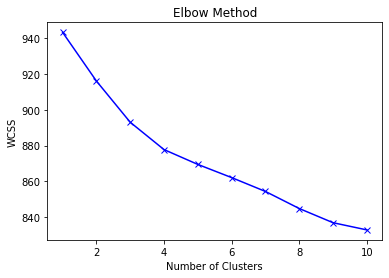

In [14]:
elbow = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(data)
    elbow.append(kmeans.inertia_)
plt.plot(range(1,11), elbow, 'bx-')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

## Compute Clusters

In [15]:
num_clusters = 4
km = KMeans(n_clusters=num_clusters)
km.fit(data)
clusters = km.labels_.tolist()

# Latent Semantic Analysis (LSA)

Cosine similarity merupakan metode untuk menghitung nilai kosinus sudut antara vektor dokumen dengan vektor query. Semakin kecil sudut yang dihasilkan, maka tingkat kemiripan esai semakin tinggi.

Formula:

$$
\cos \alpha=\frac{\boldsymbol{A} \cdot \boldsymbol{B}}{|\boldsymbol{A}||\boldsymbol{B}|}=\frac{\sum_{i=1}^{n} \boldsymbol{A}{i} X \boldsymbol{B}{i}}{\sqrt{\sum_{i=1}^{n}\left(\boldsymbol{A}{i}\right)^{2}} X \sqrt{\sum{i=1}^{n}\left(\boldsymbol{B}_{i}\right)^{2}}}
$$

Keterangan:

${A}\> \quad\quad :$ vektor dokumen

${B}\>\quad\quad :$ vektor query

${\boldsymbol{A} \cdot \boldsymbol{B}}\> :$ perkalian dot vektor$

${|\boldsymbol{A}|}\>\quad :$ panjang vektor A

${|\boldsymbol{B}|}\>\quad :$ panjang vektor B$

${|\boldsymbol{A}||\boldsymbol{B}|} :$ Perkalian panjang vektor$

$
\alpha\> \quad\quad :$ sudut yang terbentuk antara vektor A dengan vektor B

In [16]:
U, Sigma, VT = randomized_svd(data, n_components=14, random_state=0)
VT

array([[ 1.00000000e+00,  3.84838530e-13, -2.29634720e-09, ...,
         1.24583034e-34,  1.80948217e-34, -2.44664654e-36],
       [-1.51004732e-13,  1.00000000e+00,  1.93885149e-08, ...,
         4.86476601e-35, -1.67056016e-34,  1.70035701e-35],
       [ 1.69629699e-09, -1.42259032e-08,  9.99999040e-01, ...,
        -8.66462183e-35,  7.58648826e-35,  8.40159265e-36],
       ...,
       [-7.17955632e-09,  2.09695778e-08, -2.13634072e-05, ...,
        -1.43704116e-34,  1.41667042e-34,  9.07567182e-35],
       [ 6.92635753e-10, -5.93114879e-09, -2.95388286e-06, ...,
         8.15409782e-35, -3.05977382e-34, -4.18600801e-35],
       [ 2.00419145e-08, -4.11414980e-08,  4.65166960e-05, ...,
         7.15027749e-35,  3.79211344e-34, -3.90882496e-35]])

# Showing Concept

In [17]:
for i, comp in enumerate(VT):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("Concept "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])
        print(" ")

Concept 0: 
aaa
abu
acces
achmad
abstract
abnormal
absolute
 
Concept 1: 
aaaamanahsyariah
absensi
abnormar
abthal
absah
absen
abstract
 
Concept 2: 
aar
abnormal
acak
achmad
absussalam
abdullah
absolute
 
Concept 3: 
abadi
absussalam
abstrak
absen
absah
acces
absensi
 
Concept 4: 
abai
abstraksi
abstract
acak
achmad
abnormal
abidin
 
Concept 5: 
abalisis
absussalam
abstrak
abu
access
accidental
absen
 
Concept 6: 
abc
absensi
abnormar
absen
absah
acer
abthal
 
Concept 7: 
abcs
abstraksi
abthal
abnormar
absensi
abdul
abidin
 
Concept 8: 
abd
abnormar
abdul
absensi
acces
absah
absen
 
Concept 9: 
abnormar
absensi
abthal
absah
abstract
absen
abd
 
Concept 10: 
abdullah
abnormar
absensi
absah
ability
abthal
absen
 
Concept 11: 
abdurrochman
ability
abnormar
absensi
abdullah
ach
absah
 
Concept 12: 
abidin
ability
abstrak
abstract
absussalam
absolute
abnormal
 
Concept 13: 
ability
abnormal
abu
abstraksi
acces
abtrak
achmad
 


# Topic Visualization

In [18]:
X_topics = U*Sigma
embedding = umap.UMAP().fit_transform(X_topics)
embedding

array([[ 3.0799003,  5.788294 ],
       [ 2.1823118,  4.2994857],
       [ 2.5488203,  4.5032964],
       ...,
       [ 4.327521 , -5.7880297],
       [ 4.7575817, -4.1224217],
       [13.586456 ,  0.4213971]], dtype=float32)

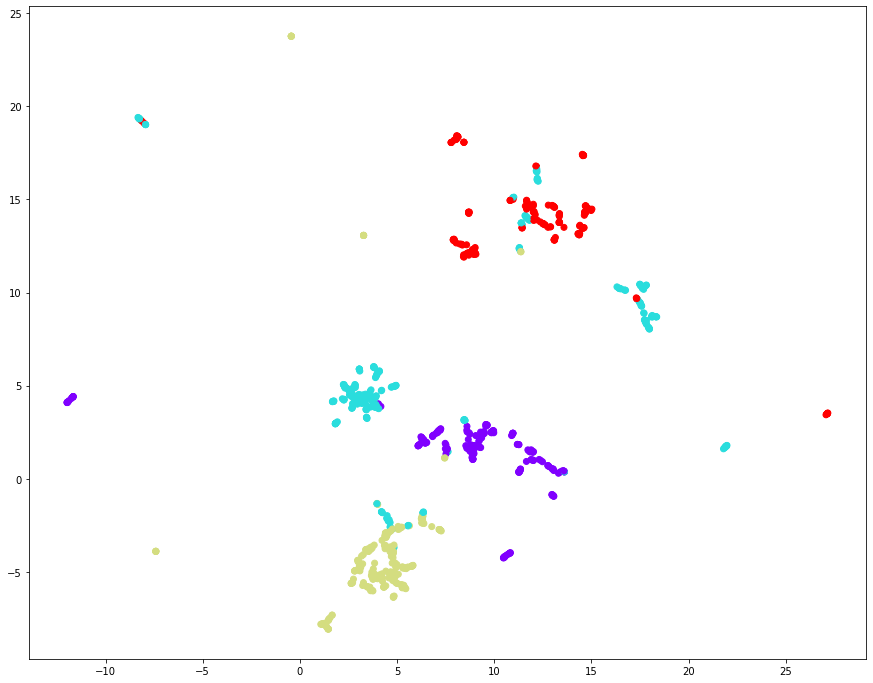

In [19]:
plt.figure(figsize=(15,12))
plt.scatter(embedding[:, 0], embedding[:, 1],c=clusters, cmap='rainbow')
plt.show()